In [132]:
import pathlib
from pathlib import Path

In [133]:
base_path = '/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture'
seg_path = Path('/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/data/segmentations')
train_images_path = Path('/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/data/train_images')
test_images_path = Path('/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/data/test_images')

In [134]:
# gather subject list and path
seg_files = list(seg_path.glob('*.nii'))
rsna_fracture_subjects = [ s.stem for s in seg_files]

train_subdirs = [f for f in train_images_path.iterdir() if f.is_dir()]
test_subdirs = [f for f in test_images_path.iterdir() if f.is_dir()]
train_subjects = [f.name for f in train_subdirs]
test_subjects = [f.name for f in test_subdirs]
print(len(train_subdirs),len(test_subdirs))

2019 3


In [135]:
# create pairs of image segmentation pairs
img_seg_pair = []
for subject, path in zip(rsna_fracture_subjects,seg_files):
    try:
        img_id = train_subjects.index(subject)
    except ValueError as e:
        print(f'could not find {subject}')
    img_seg_pair.append((subject,train_subdirs[img_id],path))


In [136]:
# write paths to file
with open('subject_list.csv','w') as f:
    f.write(f'id,subject,img_path,seg_path\n') # write header
    for i,(subject,img_path,seg_path) in enumerate(img_seg_pair):
        f.write(f'rsna-{i:02d},{subject},{img_path},{seg_path}\n')
# write subject list to file
with open('rsna_cervical.list','w') as f:
    for i,_ in enumerate(img_seg_pair):
        f.write(f'rsna-{i:02d}\n')

In [137]:
import SimpleITK as sitk
import numpy as np
def read_dicom(dicom_dir_path)->sitk.Image:
    if isinstance(dicom_dir_path,Path):
        dicom_dir_path = str(dicom_dir_path)
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir_path)
    reader.SetFileNames(dicom_names)

    image = reader.Execute()
    return image

def read_image(image_path)->sitk.Image:
    return sitk.ReadImage(image_path)
    
def save_image(img:sitk.Image,filename):
    sitk.WriteImage(img,fileName=filename)

def rsna_flip_mirror(img:sitk.Image,flip_axes)->sitk.Image:
    """flip in Z axis and mirror in X axis"""
    
    img_arr = sitk.GetArrayFromImage(img)
    flipped_img_arr = np.flip(img_arr, axis=flip_axes)
    flipped_img:sitk.Image = sitk.GetImageFromArray(flipped_img_arr)
    flipped_img.CopyInformation(img)
    return flipped_img

def get_metadata(img_path):
    reader = sitk.ImageFileReader()

    reader.SetFileName( img_path )
    reader.LoadPrivateTagsOn();

    reader.ReadImageInformation();
    return reader
    
def get_orientation(img:sitk.Image):
    return sitk.DICOMOrientImageFilter_GetOrientationFromDirectionCosines(img.GetDirection())

In [138]:
# create subjectwise directory
subjectwise_dir = Path(base_path)/'subjectwise'
subjectwise_dir.mkdir(exist_ok=True)

In [139]:
def get_stats(img:sitk.Image):
    fltr = sitk.LabelShapeStatisticsImageFilter()
    fltr.Execute(img)
    return fltr

In [140]:
from tqdm import tqdm
for id, (subject,img_path, seg_path) in tqdm(enumerate(img_seg_pair)):
    ct = read_dicom(str(img_path))
    ct_axcode = sitk.DICOMOrientImageFilter_GetOrientationFromDirectionCosines(ct.GetDirection())
    ct_path = Path(subjectwise_dir)/f'rsna-{id:02d}'
    ct_path.mkdir(exist_ok=True)
    save_image(ct,str(ct_path/'ct.nii.gz'))

    seg = read_image(str(seg_path))
    seg = sitk.DICOMOrient(seg,ct_axcode)
    save_image(seg,str(ct_path/'seg.nii.gz'))
    print(ct_path)


1it [00:20, 20.88s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-00


ImageSeriesReader (0x7adea20): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0005

2it [01:29, 49.04s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-01


3it [01:40, 31.71s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-02


4it [02:00, 27.12s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-03


5it [02:25, 26.20s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-04


6it [03:00, 29.38s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-05


7it [03:34, 30.81s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-06


8it [04:17, 34.55s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-07


9it [04:27, 26.87s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-08


10it [04:43, 23.59s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-09


11it [04:50, 18.62s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-10


12it [05:13, 19.94s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-11


13it [05:41, 22.24s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-12


14it [05:50, 18.32s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-13


15it [06:08, 18.10s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-14


16it [06:21, 16.55s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-15


17it [06:49, 20.15s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-16


18it [07:07, 19.49s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-17


19it [07:29, 20.20s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-18


20it [07:54, 21.80s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-19


21it [08:28, 25.18s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-20


22it [09:07, 29.56s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-21


23it [09:37, 29.58s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-22


24it [10:14, 31.94s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-23


25it [10:49, 32.77s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-24


26it [11:19, 32.03s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-25


27it [11:34, 26.83s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-26


28it [11:58, 26.08s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-27


29it [12:10, 21.72s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-28


30it [12:48, 26.75s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-29


31it [13:15, 26.54s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-30


32it [13:41, 26.50s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-31


33it [14:13, 28.28s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-32


34it [14:25, 23.43s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-33


35it [14:54, 24.98s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-34


ImageSeriesReader (0x7adea20): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000501667

36it [16:04, 38.48s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-35


37it [16:27, 33.91s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-36


38it [17:11, 36.98s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-37


39it [17:35, 32.95s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-38


40it [18:02, 31.28s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-39


41it [18:20, 27.26s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-40


42it [18:34, 23.34s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-41


43it [19:04, 25.17s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-42


44it [19:33, 26.46s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-43


45it [19:46, 22.43s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-44


46it [20:17, 24.79s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-45


ImageSeriesReader (0x7adea20): Non uniform sampling or missing slices detected,  maximum nonuniformity:6.08802e-05

47it [20:56, 29.16s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-46


48it [21:28, 29.93s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-47


49it [21:42, 25.37s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-48


50it [22:36, 33.96s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-49


51it [23:15, 35.34s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-50


52it [23:28, 28.71s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-51


53it [23:40, 23.49s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-52


54it [23:52, 20.24s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-53


55it [24:41, 28.74s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-54


56it [24:56, 24.60s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-55


57it [25:07, 20.69s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-56


58it [25:39, 24.01s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-57


59it [26:36, 33.87s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-58


60it [27:05, 32.46s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-59


61it [27:17, 26.40s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-60


62it [27:56, 30.19s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-61


63it [28:25, 29.60s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-62


64it [29:00, 31.45s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-63


65it [29:42, 34.58s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-64


66it [29:54, 27.67s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-65


67it [30:28, 29.73s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-66


68it [30:42, 25.04s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-67


69it [31:08, 25.10s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-68


70it [31:46, 28.99s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-69


71it [31:59, 24.29s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-70


72it [32:32, 26.78s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-71


73it [32:48, 23.62s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-72


74it [33:11, 23.43s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-73


75it [33:29, 21.83s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-74


76it [34:06, 26.27s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-75


77it [34:32, 26.34s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-76


78it [34:59, 26.47s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-77


79it [35:15, 23.37s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-78


80it [35:47, 25.87s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-79


81it [36:52, 37.62s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-80


82it [37:04, 30.05s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-81


83it [37:32, 29.36s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-82


84it [37:50, 26.00s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-83


85it [38:38, 32.44s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-84


ImageSeriesReader (0x7adea20): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0005

86it [40:09, 50.05s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-85


87it [40:20, 27.82s/it]

/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/subjectwise/rsna-86


In [141]:
# get voxel count
import pandas as pd
df = pd.read_csv('subject_list.csv')
subjectwise_dir = Path(base_path)/'subjectwise'

voxel_count = []
vertebra_count = []
nonborder_vertebra_count = []
for id,subject,img_path,seg_path in df.to_numpy():
    seg  = subjectwise_dir/id/'seg.nii.gz'

    stats = get_stats(sitk.ReadImage(str(seg)))
    voxel_count.append([stats.GetNumberOfPixelsOnBorder(l) for l in stats.GetLabels()])
    vertebra_count.append(len(stats.GetLabels()))
    nonborder_vertebra_count.append(len([ 0 if stats.GetNumberOfPixelsOnBorder(l) >0 else 1 for l in stats.GetLabels()]))


In [142]:
np.sum(vertebra_count),np.sum(nonborder_vertebra_count)

(922, 922)

In [143]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['lines.markersize'] = 10

In [144]:
from math import floor,log10
def format_func(value, tick_number=None):
    num_thousands = 0 if abs(value) < 1000 else floor (log10(abs(value))/3)
    value = round(value / 1000**num_thousands, 2)
    return f'{value:g}'+' KMGTPEZY'[num_thousands]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


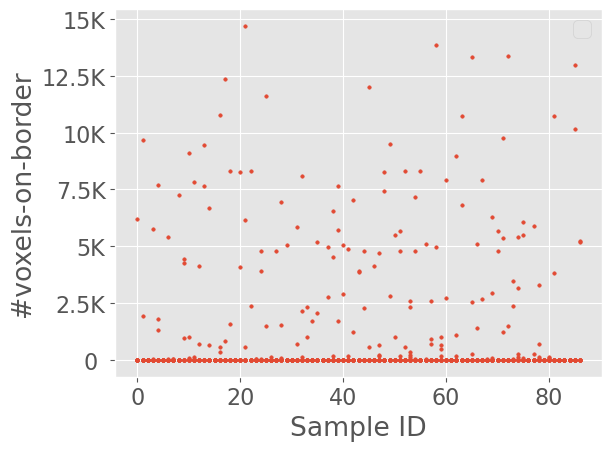

In [145]:
fig, ax = plt.subplots()
for id,v in enumerate(voxel_count):
    plt.scatter(x = (id,)*len(v),y=v,label='',s=6,c='#E24A33')
# plt.axhline(y=30000,linestyle='--',label='30k voxels',color='k')
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.ylabel('#voxels-on-border')
plt.xlabel('Sample ID')
plt.legend()
plt.tight_layout()